<a href="https://colab.research.google.com/github/Luseat/Prediksi-IHSG/blob/main/forecasting_IHSG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error
import yfinance as yf
import seaborn as sns
import matplotlib.dates as mdates

**Import Data IHSG**

In [30]:
start_date = "2017-01-01"
end_date = "2025-03-29"

data = yf.Ticker("^JKSE")
data = data.history(start=start_date, end=end_date)
del data['Dividends']
del data['Stock Splits']
forcaseData = data.copy()
data.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2025-03-21 00:00:00+07:00,6418.390137,6426.165039,6218.601074,6258.179199,190225100
2025-03-24 00:00:00+07:00,6242.234863,6269.903809,5967.193848,6161.217773,124187900
2025-03-25 00:00:00+07:00,6197.986816,6265.295898,6178.490234,6235.619141,111267000
2025-03-26 00:00:00+07:00,6314.329102,6489.148926,6312.966797,6472.355957,159762700
2025-03-27 00:00:00+07:00,6462.596191,6510.620117,6417.240234,6510.620117,121855500


**Penutupan harga indeks IHSG**

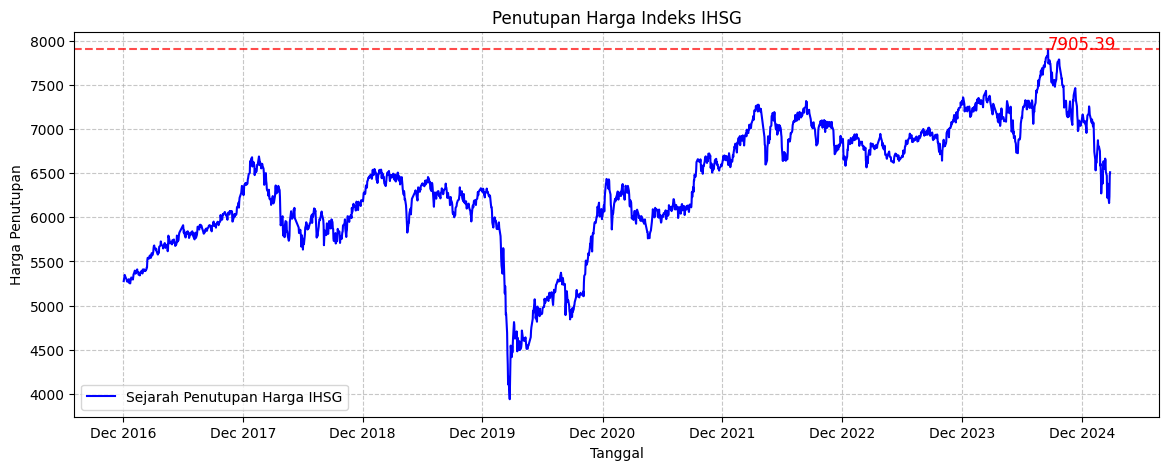

In [43]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=data, x=data.index, y='Close', label='Sejarah Penutupan Harga IHSG', color='blue')

max_price = data['Close'].max()
max_price_date = data['Close'].idxmax()

#Annotate the Highest price
plt.annotate(f'{max_price:.2f}',
             xy=(max_price_date, max_price),
             xytext=(max_price_date, max_price + 2),
             fontsize=12, color='red')

plt.axhline(max_price, linestyle='--', color='red', alpha=0.7)
plt.title('Penutupan Harga Indeks IHSG')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

**Preprocessing**

In [45]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
scaled_data

array([[0.33730361],
       [0.34365781],
       [0.34978741],
       ...,
       [0.57916512],
       [0.63883025],
       [0.64847402]])

In [46]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length, 0])
    return np.array(sequences), np.array(labels)

In [49]:
sequence_length = 60 # dalam 2 bulan kedepan

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

**Training Data (LSTM)**

In [50]:
model = Sequential()

#layer pertama LSTM
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

#layer kedua LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

#Dense layer
model.add(Dense(units=25))
model.add(Dense(units=1))




In [51]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=200, batch_size=84, validation_data=(X_test, y_test))

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.1523 - val_loss: 0.0582
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0143 - val_loss: 0.0068
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0055 - val_loss: 0.0039
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0046 - val_loss: 0.0024
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 8/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 9/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 10/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 11/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 12/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/s

**Evaluasi**

In [52]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_scaled, predictions) #y_test_scaled
print(f'Mean Squared Error (MSE): {mse}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Mean Squared Error (MSE): 5761.152249441738


**Prediksi dalam 2 bulan kedepan**

In [53]:
last_60_days = data['Close'][-sequence_length:].values.reshape(-1, 1)
last_60_days_scaled = scaler.transform(last_60_days)

X_predict = []
X_predict.append(last_60_days_scaled)

X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))
predicted_price = model.predict(X_predict)
predicted_price = scaler.inverse_transform(predicted_price)
print(f'Prediksi Harga : {predicted_price[0][0]}')

# next_day_prediction = model.predict(np.array([last_60_days_scaled]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediksi Harga : 6489.09912109375


In [24]:
future_days = 60

last_60_days = data['Close'][-sequence_length:].values.reshape(-1, 1)
last_60_days_scaled = scaler.transform(last_60_days)
future_predictions = []

for i in range(future_days):
    X_predict = []
    X_predict.append(last_60_days_scaled)
    X_predict = np.array(X_predict)
    X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

    predicted_price = model.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)
    future_predictions.append(predicted_price_unscaled[0, 0])

    new_scaled_data = np.append(last_60_days_scaled[1:], predicted_price, axis=0)
    last_60_days_scaled = new_scaled_data.reshape(-1, 1)

future_dates = pd.date_range(start=data.index[-1], periods=future_days + 1, freq='D')[1:] # 0 O o

future_predictions_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': future_predictions})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

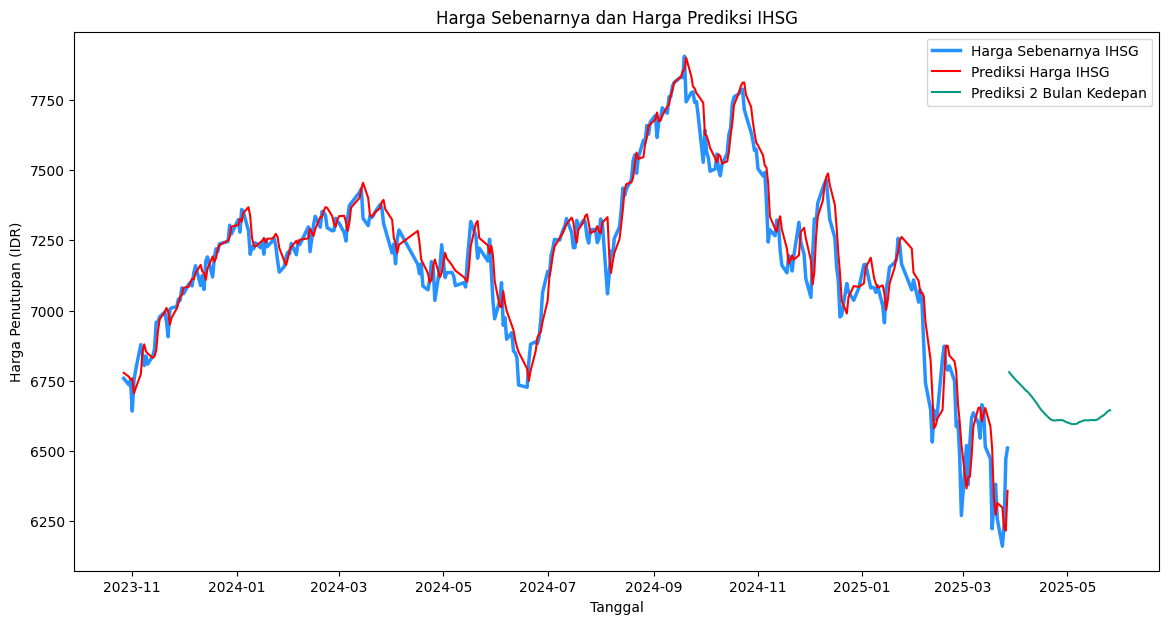

In [58]:
plt.figure(figsize=(14, 7))

plt.plot(data.index[-len(y_test_scaled):], y_test_scaled, label='Harga Sebenarnya IHSG', color='#2692ff', linewidth=2.5)
plt.plot(data.index[-len(y_test_scaled):], predictions, label='Prediksi Harga IHSG', color='red', linewidth=1.5)
plt.plot(future_dates, future_predictions, label='Prediksi 2 Bulan Kedepan', color='#089981', linewidth=1.5)

plt.title('Harga Sebenarnya dan Harga Prediksi IHSG')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan (IDR)')
plt.legend()

plt.show()